In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import normal

### **00.** 트레이닝 셋 생성

In [ ]:
np.random.seed(0) # 동일한 세트의 난수 생성

N = 10 # 관측점/관측값 개수 {(x_n, t_n)} (n=1,...,N)

In [ ]:
# 최소제곱법에 사용할 "램덤" 데이터 셋 생성 함수
# N개의 관측점/관측값 {(x_n, y_n)}을 포함하는 DataFrame 생성하여 반환
def create_dataset(N):
    dataset = pd.DataFrame(columns=['x','t'])
    for i in range(N):
        x = float(i)/float(N-1)
        t = np.sin(2*np.pi*x) + normal(scale = 0.3)
            # scale은 standard deviation.
        dataset = dataset.append(pd.Series([x,t],index=['x','t']),
                                 ignore_index = True)
            # pandas.DataFrame.append(): 새로운 객체 반환. index가 0,1,...
    return dataset

In [ ]:
# 트레이닝 데이터 셋 생성
training_set = create_dataset(N) # 위에서 정의한 관측점/관측값 개수 N


# N개의 관측점/관측값 가지는 트레이닝 셋 DataFrame 출력
pd.options.display.float_format = '{:.2f}'.format
training_set

,x,t
0,0.00,0.53
1,0.11,0.76
2,0.22,1.28
3,0.33,1.54
4,0.44,0.90
5,0.56,-0.64
6,0.67,-0.58
7,0.78,-1.03
8,0.89,-0.67
9,1.00,0.12


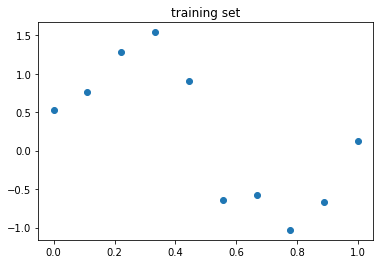

In [ ]:
# 트레이닝 셋 그래프 출력
x = training_set['x'] # x는 pandas.core.series.Series 객체.
t = training_set['t'] # t는 pandas.core.series.Series 객체.

plt.scatter(x,t)
plt.title('training set')
plt.show()

### **01** $\mathbf{t}, \mathbf{\Phi}, \mathbf{w}$ 계산


$\mathbf{t} = \begin{pmatrix} t_1 \\\\ \vdots \\\\ t_N \end{pmatrix} , \,\mathbf{\Phi} = \begin{pmatrix} x_1^0 & \cdots & x_1^M \\\\ \vdots & \ddots & \vdots \\\\ x_N^0 & \cdots & x_N^M \end{pmatrix} $

In [ ]:
def calc_t(dataset):
    return dataset.t.values.reshape(-1,1) # shape = (N,1) 

def calc_phi(dataset, M):
    x = dataset.x.values.reshape(-1,1)
    phi = np.repeat(x, M+1, axis = 1)
    phi = np.power(phi, np.arange(M+1)) #np.arange(M+1) = [0,1,2, ... , M]

    return phi

$
\mathbf{w} = \begin{pmatrix} w_0 \\\\ \vdots \\\\ w_M \end{pmatrix}
= \left ( \mathbf{\Phi}^T \mathbf{\Phi} \right )^{-1} \mathbf{\Phi}^T \mathbf{t}, \; 
$ 

In [ ]:
def calc_w(training_set, M):
    phi = calc_phi(training_set,M)
    t = calc_t(training_set)

    phiT_phi_inv = np.linalg.inv(phi.T.dot(phi))
    w = np.linalg.multi_dot([phiT_phi_inv,phi.T,t])
    return w

$f(x) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M = \sum_{m=0}^{M} {w_m x^m} $


In [ ]:
def calc_polynomial_values(w, xs):
    ys = np.zeros(xs.size)
    for m, w_m in enumerate(w):
        ys += w_m * (xs ** m)
    return ys

### **02.** $E_{rms}$ 계산 

$E_D = \frac{1}{2} \sum_{n=1}^{N} \left \{ f(x_n) - t_n \right \}^{2} $

$E_{RMS} = \sqrt{ \frac{2E_D}{N} }$

In [ ]:
# 제곱근 평균 제곱 오차(Root mean square error) 계산
def calc_rms_error(dataset, w):
    Ed = 0.0
    N = len(dataset)
    
    # x value: line.x  t value: line.t
    for _, line in dataset.iterrows(): # (index, Series) pairs.
        x, t = line.x, line.t
        Ed += 0.5 * (calc_polynomial_values(w,x)-t)**2
    rms_error = np.sqrt(2 * Ed / N)
    return rms_error

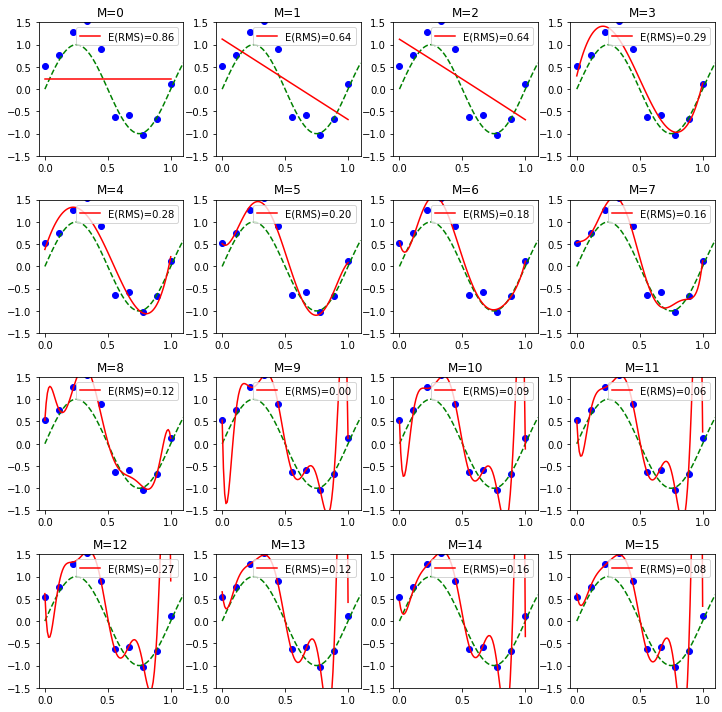

In [ ]:
Ms = range(16) # 최소제곱법 다항식 차수 리스트

# 최소제곱법으로 구한 0, 1, 3, 9차 다항식 시각화
fig = plt.figure(figsize=(10,10))

for c, M in enumerate(Ms):
    w = calc_w(training_set,M)
    rms_error = calc_rms_error(training_set,w)
    
    subplot = fig.add_subplot(4,4,c+1)
    subplot.set_xlim(-0.05,1.1)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % M)

    # 트레이닝 셋 표시
    subplot.scatter(training_set.x, training_set.t, marker='o', color='blue')

    # sin 곡선 표시
    linex = np.linspace(0,1.1,101) # numpy.ndarray (101,)
    liney = np.sin(2*np.pi*linex) # numpy.ndarray (101,)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 다항식 근사 곡선 표시
    linex = np.linspace(0,1,101)
    liney = calc_polynomial(w, linex)

    # error값 표시
    #label = ""
    label = "E(RMS)=%.2f" % rms_error
    subplot.plot(linex, liney, color='red', label=label)
    subplot.legend(loc=1)

fig.tight_layout() # 그래프 간의 간격 조절